In [19]:
# Model 3: Career Role Recommendation System
# Hybrid KNN + Cosine Similarity Approach
# 
# This model takes career clusters as input from Model 2 and predicts specific career roles using a hybrid approach combining:
# - Content-based filtering using cosine similarity on skills
# - Collaborative filtering using KNN on user features
# - Popularity-based scoring
#
# Input: Career Cluster (from Model 2)
# Output: Top 2-4 Career Roles with comprehensive career guidance

In [20]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")
print("Model 3 training initiated")

Libraries imported successfully
Model 3 training initiated


In [21]:
# Step 2: Load Dataset
# Load the career role dataset
df = pd.read_csv('E:\College\SEM_5\CPRS_AI\server\ml_models\datasets\DS3_Career_Role_Recommendation.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nCareer clusters: {sorted(df['CareerCluster'].unique())}")
print(f"Total clusters: {df['CareerCluster'].nunique()}")
print(f"Total roles: {df['CareerRole'].nunique()}")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Display first few rows
print(f"\nFirst 3 rows:")
df.head(3)

Dataset shape: (319, 12)
Columns: ['CareerCluster', 'CareerRole', 'RequiredSkills', 'EducationLevelRequired', 'AvgSalaryRange', 'JobOutlook', 'GrowthPath', 'LearningResources', 'EntranceExams', 'FieldforAdmission', 'OnlineResourcesLinks', 'FreeCertifications']

Career clusters: ['Arts', 'Business', 'Consulting', 'Design', 'Education', 'Finance', 'Healthcare', 'IT', 'Law', 'Legal', 'Marketing', 'Media', 'Research', 'STEM', 'Sales', 'Service']
Total clusters: 16
Total roles: 298

Missing values:
CareerCluster             0
CareerRole                0
RequiredSkills            0
EducationLevelRequired    0
AvgSalaryRange            0
JobOutlook                0
GrowthPath                0
LearningResources         0
EntranceExams             0
FieldforAdmission         0
OnlineResourcesLinks      0
FreeCertifications        0
dtype: int64

First 3 rows:


,CareerCluster,CareerRole,RequiredSkills,EducationLevelRequired,AvgSalaryRange,JobOutlook,GrowthPath,LearningResources,EntranceExams,FieldforAdmission,OnlineResourcesLinks,FreeCertifications
0,STEM,Data Scientist,Python; R; MATLAB; Statistics; Research; Probl...,Post-graduation,13-40 LPA,Very High,Entry Level > Data Scientist > Senior Data Sci...,Khan Academy; MIT OpenCourseWare; Coursera Sci...,Competitive Exams; Interviews,Relevant Bachelor/Master Degree,https://khanacademy.org; https://mit.edu/cours...,IBM Data Science; Google Analytics; Microsoft ...
1,STEM,Machine Learning Engineer,Python; R; MATLAB; Statistics; Research; Machi...,Graduation,7-25 LPA,Very High,Entry Level > Machine Learning Engineer > Seni...,Khan Academy; MIT OpenCourseWare; Coursera Sci...,JEE Main; JEE Advanced; State CET,B.Tech/B.E in relevant field,https://khanacademy.org; https://mit.edu/cours...,IBM Data Science; Google Analytics; Microsoft ...
2,STEM,Research Scientist,Python; R; MATLAB; Statistics; Research; Techn...,Post-graduation,13-40 LPA,Very High,Entry Level > Research Scientist > Senior Rese...,Khan Academy; MIT OpenCourseWare; Coursera Sci...,Competitive Exams; Interviews,Relevant Bachelor/Master Degree,https://khanacademy.org; https://mit.edu/cours...,IBM Data Science; Google Analytics; Microsoft ...


In [22]:
# Step 3: Data Preprocessing

# Function to preprocess skills
def preprocess_skills(skills_str):
    if pd.isna(skills_str) or skills_str == 'N/A':
        return []
    return [skill.strip().lower() for skill in skills_str.split(';') if skill.strip()]

# Process skills column
df['SkillsList'] = df['RequiredSkills'].apply(preprocess_skills)
df['SkillsText'] = df['RequiredSkills'].fillna('')

# Extract salary midpoint
def extract_salary_midpoint(salary_str):
    try:
        if pd.isna(salary_str) or salary_str == 'N/A':
            return 10
        numbers = salary_str.split(' ')[0].split('-')
        if len(numbers) == 2:
            return (float(numbers[0]) + float(numbers[1])) / 2
        return 10
    except:
        return 10

df['SalaryMidpoint'] = df['AvgSalaryRange'].apply(extract_salary_midpoint)

# Encode categorical features
le_education = LabelEncoder()
le_outlook = LabelEncoder()
le_cluster = LabelEncoder()

df['EducationEnc'] = le_education.fit_transform(df['EducationLevelRequired'].fillna('Graduation'))
df['OutlookEnc'] = le_outlook.fit_transform(df['JobOutlook'].fillna('Medium'))
df['ClusterEnc'] = le_cluster.fit_transform(df['CareerCluster'])

print("Data preprocessing completed")
print(f"Education levels: {list(le_education.classes_)}")
print(f"Job outlooks: {list(le_outlook.classes_)}")
print(f"Salary range: {df['SalaryMidpoint'].min():.1f} - {df['SalaryMidpoint'].max():.1f} LPA")

Data preprocessing completed
Education levels: ['12th Pass', 'Diploma', 'Graduation', 'PhD', 'Post-graduation']
Job outlooks: ['High', 'Low', 'Medium', 'Very High']
Salary range: 5.5 - 37.5 LPA


In [23]:
# Step 4: Skills Vectorization using TF-IDF

# Create TF-IDF vectors for skills
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95
)

# Fit and transform skills text
skills_tfidf_matrix = tfidf_vectorizer.fit_transform(df['SkillsText'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF matrix shape: {skills_tfidf_matrix.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Top 10 features: {list(feature_names[:10])}")

# Create skills count feature
df['SkillsCount'] = df['SkillsList'].apply(len)
print(f"Average skills per role: {df['SkillsCount'].mean():.1f}")

TF-IDF matrix shape: (319, 500)
Number of features: 500
Top 10 features: ['3d', 'academic', 'account', 'account management', 'account planning', 'accounting', 'administration', 'administration cloud', 'administration database', 'adobe']
Average skills per role: 6.0


Content similarity matrix shape: (319, 319)


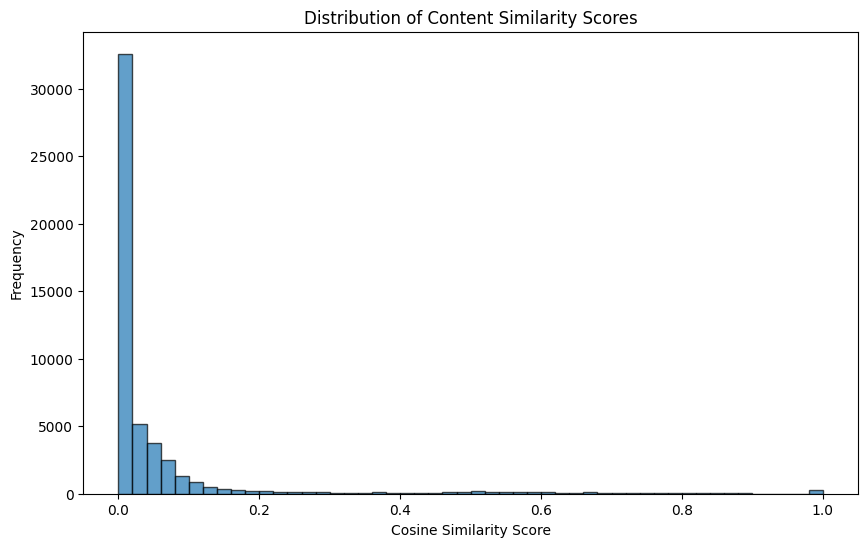

Mean similarity: 0.054
Std similarity: 0.138
Content-based filtering setup completed


In [24]:
# Step 5: Content-Based Filtering - Cosine Similarity

# Calculate cosine similarity matrix for skills
content_similarity_matrix = cosine_similarity(skills_tfidf_matrix)

print(f"Content similarity matrix shape: {content_similarity_matrix.shape}")

# Analyze similarity distribution
similarity_scores = content_similarity_matrix[np.triu_indices_from(content_similarity_matrix, k=1)]

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Content Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()

print(f"Mean similarity: {similarity_scores.mean():.3f}")
print(f"Std similarity: {similarity_scores.std():.3f}")
print("Content-based filtering setup completed")

KNN model fitted successfully
Feature matrix shape: (319, 4)
Number of neighbors: 15


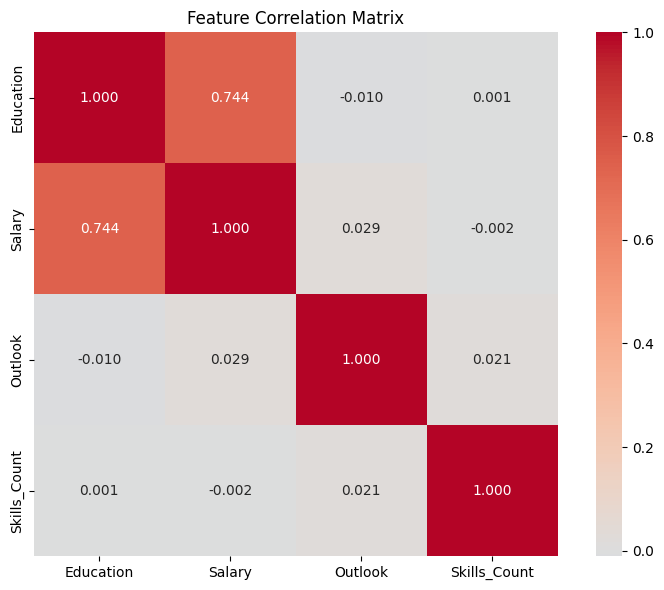

Collaborative filtering setup completed


In [25]:
# Step 6: Collaborative Filtering - KNN Setup

# Prepare features for collaborative filtering
collab_features = df[['EducationEnc', 'SalaryMidpoint', 'OutlookEnc', 'SkillsCount']].values

# Standardize features
scaler = StandardScaler()
collab_features_scaled = scaler.fit_transform(collab_features)

# Initialize KNN model
knn_model = NearestNeighbors(
    n_neighbors=min(15, len(df)),
    metric='euclidean',
    algorithm='auto'
)

# Fit KNN model
knn_model.fit(collab_features_scaled)

print(f"KNN model fitted successfully")
print(f"Feature matrix shape: {collab_features_scaled.shape}")
print(f"Number of neighbors: {knn_model.n_neighbors}")

# Visualize feature correlations
feature_df = pd.DataFrame(collab_features, 
                         columns=['Education', 'Salary', 'Outlook', 'Skills_Count'])

plt.figure(figsize=(8, 6))
correlation_matrix = feature_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Collaborative filtering setup completed")

In [26]:
# Step 7: Hybrid Recommendation System Class

class HybridCareerRecommender:
    def __init__(self, df, content_sim_matrix, knn_model, scaler, tfidf_vectorizer, label_encoders):
        self.df = df
        self.content_sim_matrix = content_sim_matrix
        self.knn_model = knn_model
        self.scaler = scaler
        self.tfidf_vectorizer = tfidf_vectorizer
        self.label_encoders = label_encoders
    
    def get_content_scores(self, cluster_indices):
        """Calculate content-based similarity scores"""
        if len(cluster_indices) == 0:
            return np.array([])
        
        cluster_sim_matrix = self.content_sim_matrix[np.ix_(cluster_indices, cluster_indices)]
        content_scores = cluster_sim_matrix.mean(axis=1)
        return content_scores
    
    def get_collaborative_scores(self, cluster_indices):
        """Calculate collaborative filtering scores using KNN"""
        if len(cluster_indices) == 0:
            return np.array([])
        
        cluster_features = collab_features_scaled[cluster_indices]
        n_neighbors = min(10, len(cluster_indices))
        
        distances, neighbors = self.knn_model.kneighbors(
            cluster_features, n_neighbors=n_neighbors
        )
        
        # Convert distances to similarity scores
        collab_scores = []
        for dist_array in distances:
            similarity = 1 / (1 + dist_array.mean())
            collab_scores.append(similarity)
        
        return np.array(collab_scores)
    
    def get_popularity_scores(self, cluster_data):
        """Calculate popularity scores based on job outlook and salary"""
        popularity_scores = []
        
        outlook_weights = {'Low': 0.2, 'Medium': 0.5, 'High': 0.8, 'Very High': 1.0}
        
        for _, row in cluster_data.iterrows():
            outlook_score = outlook_weights.get(row['JobOutlook'], 0.5)
            salary_score = min(row['SalaryMidpoint'] / 25.0, 1.0)
            popularity = (outlook_score * 0.6) + (salary_score * 0.4)
            popularity_scores.append(popularity)
        
        return np.array(popularity_scores)
    
    def recommend_roles(self, career_cluster, user_education=None, top_n=4, 
                       content_weight=0.4, collab_weight=0.3, popularity_weight=0.3):
        """
        Generate hybrid career role recommendations
        
        Parameters:
        - career_cluster: Target career cluster
        - user_education: User's education level
        - top_n: Number of recommendations (2-4)
        - content_weight: Weight for content-based filtering
        - collab_weight: Weight for collaborative filtering
        - popularity_weight: Weight for popularity scoring
        """
        
        # Filter data by career cluster
        cluster_data = self.df[self.df['CareerCluster'] == career_cluster].copy()
        
        if cluster_data.empty:
            return {
                'status': 'error',
                'message': f'No roles found for cluster: {career_cluster}',
                'recommendations': []
            }
        
        cluster_indices = cluster_data.index.tolist()
        
        # Calculate different recommendation scores
        content_scores = self.get_content_scores(cluster_indices)
        collab_scores = self.get_collaborative_scores(cluster_indices)
        popularity_scores = self.get_popularity_scores(cluster_data)
        
        # Normalize scores to 0-1 range
        def normalize_scores(scores):
            if len(scores) == 0 or scores.std() == 0:
                return scores
            return (scores - scores.min()) / (scores.max() - scores.min())
        
        content_norm = normalize_scores(content_scores)
        collab_norm = normalize_scores(collab_scores)
        popularity_norm = normalize_scores(popularity_scores)
        
        # Calculate hybrid scores
        hybrid_scores = (content_weight * content_norm + 
                        collab_weight * collab_norm + 
                        popularity_weight * popularity_norm)
        
        # Boost scores for matching education level
        if user_education:
            education_match = cluster_data['EducationLevelRequired'] == user_education
            hybrid_scores += education_match.values * 0.15
        
        # Get top recommendations
        top_indices = np.argsort(-hybrid_scores)[:top_n]
        
        # Prepare recommendations
        recommendations = []
        for i, idx in enumerate(top_indices):
            row = cluster_data.iloc[idx]
            
            recommendation = {
                'rank': i + 1,
                'career_role': row['CareerRole'],
                'career_cluster': career_cluster,
                'required_skills': row['RequiredSkills'],
                'education_level_required': row['EducationLevelRequired'],
                'avg_salary_range': row['AvgSalaryRange'],
                'job_outlook': row['JobOutlook'],
                'growth_path': row['GrowthPath'],
                'learning_resources': row['LearningResources'],
                'entrance_exams': row['EntranceExams'],
                'field_for_admission': row['FieldforAdmission'],
                'online_resources_links': row['OnlineResourcesLinks'],
                'free_certifications': row['FreeCertifications'],
                'confidence_score': round(float(hybrid_scores[idx]), 3),
                'content_score': round(float(content_norm[idx]), 3) if len(content_norm) > idx else 0,
                'collaborative_score': round(float(collab_norm[idx]), 3) if len(collab_norm) > idx else 0,
                'popularity_score': round(float(popularity_norm[idx]), 3)
            }
            recommendations.append(recommendation)
        
        return {
            'status': 'success',
            'career_cluster': career_cluster,
            'total_recommendations': len(recommendations),
            'user_education': user_education,
            'recommendations': recommendations
        }

# Initialize the hybrid recommender
label_encoders = {
    'education': le_education,
    'outlook': le_outlook,
    'cluster': le_cluster
}

recommender = HybridCareerRecommender(
    df=df,
    content_sim_matrix=content_similarity_matrix,
    knn_model=knn_model,
    scaler=scaler,
    tfidf_vectorizer=tfidf_vectorizer,
    label_encoders=label_encoders
)

print("Hybrid Career Recommender initialized successfully")

Hybrid Career Recommender initialized successfully


In [27]:
# Step 8: Test Recommendations

def test_model_recommendations(test_clusters, user_education=None, top_n=4):
    """Test the model with different career clusters"""
    for cluster in test_clusters:
        print(f"TESTING CLUSTER: {cluster}")
        if user_education:
            print(f"User Education: {user_education}")
        
        result = recommender.recommend_roles(
            career_cluster=cluster,
            user_education=user_education,
            top_n=top_n
        )
        
        if result['status'] == 'error':
            print(f"Error: {result['message']}")
            continue
        
        print(f"Total recommendations: {result['total_recommendations']}")
        
        for rec in result['recommendations']:
            print(f"\n{rec['rank']}. {rec['career_role']}")
            print(f"   Education: {rec['education_level_required']}")
            print(f"   Salary: {rec['avg_salary_range']}")
            print(f"   Outlook: {rec['job_outlook']}")
            print(f"   Confidence: {rec['confidence_score']}")
            print(f"   Skills: {rec['required_skills'][:80]}...")

# Test with sample clusters
test_clusters = ['IT', 'Healthcare', 'Business', 'STEM']
test_model_recommendations(test_clusters, user_education='Graduation', top_n=3)

TESTING CLUSTER: IT
User Education: Graduation
Total recommendations: 3

1. DevOps Engineer
   Education: Graduation
   Salary: 7-25 LPA
   Outlook: Very High
   Confidence: 1.026
   Skills: Programming; Problem Solving; Debugging; Version Control; System Administration;...

2. Data Engineer
   Education: Graduation
   Salary: 7-25 LPA
   Outlook: Very High
   Confidence: 1.026
   Skills: Programming; Problem Solving; Debugging; Version Control; System Administration;...

3. Web Developer
   Education: Graduation
   Salary: 7-25 LPA
   Outlook: Very High
   Confidence: 0.938
   Skills: Programming; Problem Solving; Debugging; Version Control; JavaScript; React...
TESTING CLUSTER: Healthcare
User Education: Graduation
Total recommendations: 3

1. Dentist
   Education: Post-graduation
   Salary: 15-40 LPA
   Outlook: High
   Confidence: 0.923
   Skills: Medical Knowledge; Patient Care; Communication; Empathy; Diagnosis; Dental Proce...

2. Pharmacist
   Education: Graduation
   Salary: 9

MODEL PERFORMANCE ANALYSIS
       cluster  avg_confidence  avg_content  avg_collaborative  \
0         STEM           0.783        0.806              0.891   
1           IT           0.823        0.839              1.000   
2     Business           0.891        1.000              0.874   
3   Healthcare           0.881        0.872              0.980   
4         Arts           0.814        0.836              0.948   
5    Education           0.848        0.757              0.968   
6      Finance           0.780        0.656              1.000   
7        Legal           0.762        0.707              0.939   
8       Design           0.866        0.851              0.855   
9        Media           0.701        0.696              0.598   
10   Marketing           0.750        0.740              0.713   
11       Sales           0.698        0.787              0.722   
12    Research           0.790        0.796              0.768   
13  Consulting           0.681        0.699      

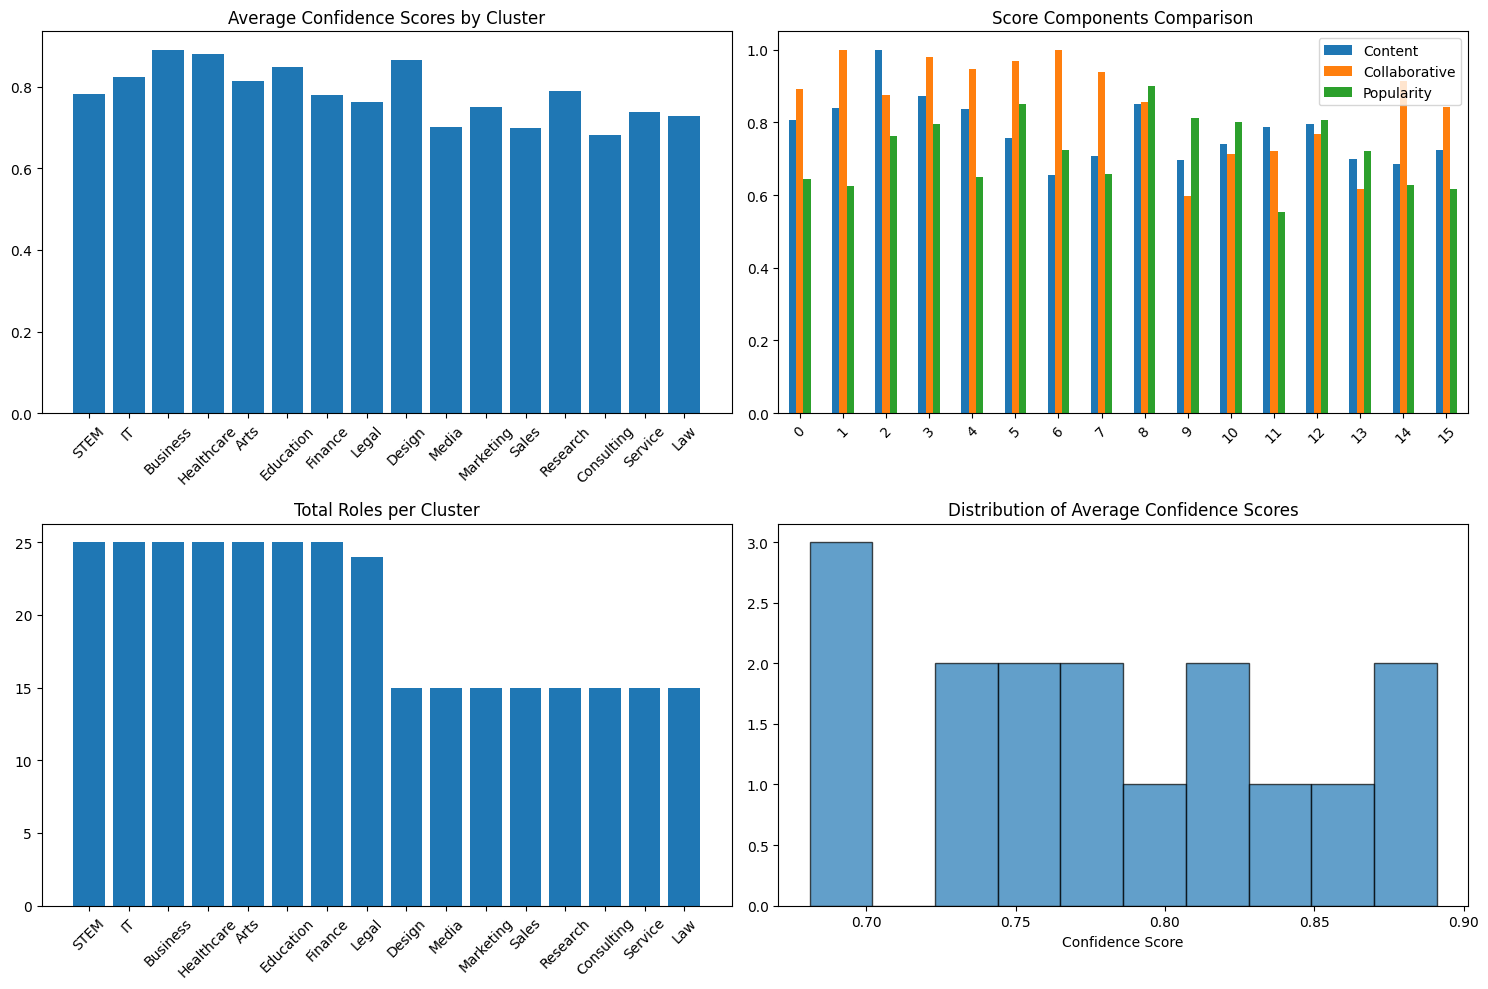

In [28]:
# Step 9: Model Performance Evaluation

def evaluate_model_performance():
    """Evaluate model performance across all clusters"""
    performance_results = []
    
    all_clusters = df['CareerCluster'].unique()
    
    for cluster in all_clusters:
        result = recommender.recommend_roles(cluster, top_n=5)
        
        if result['status'] == 'success':
            recommendations = result['recommendations']
            
            # Calculate average scores
            avg_confidence = np.mean([rec['confidence_score'] for rec in recommendations])
            avg_content = np.mean([rec['content_score'] for rec in recommendations])
            avg_collab = np.mean([rec['collaborative_score'] for rec in recommendations])
            avg_popularity = np.mean([rec['popularity_score'] for rec in recommendations])
            
            performance_results.append({
                'cluster': cluster,
                'avg_confidence': avg_confidence,
                'avg_content': avg_content,
                'avg_collaborative': avg_collab,
                'avg_popularity': avg_popularity,
                'total_roles': len(df[df['CareerCluster'] == cluster]),
                'recommendations_count': len(recommendations)
            })
    
    performance_df = pd.DataFrame(performance_results)
    
    print("MODEL PERFORMANCE ANALYSIS")
    print("=" * 50)
    print(performance_df.round(3))
    
    # Performance statistics
    print(f"\nOverall Performance Statistics:")
    print(f"Average Confidence Score: {performance_df['avg_confidence'].mean():.3f}")
    print(f"Standard Deviation: {performance_df['avg_confidence'].std():.3f}")
    print(f"Min Confidence Score: {performance_df['avg_confidence'].min():.3f}")
    print(f"Max Confidence Score: {performance_df['avg_confidence'].max():.3f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Confidence scores by cluster
    axes[0,0].bar(performance_df['cluster'], performance_df['avg_confidence'])
    axes[0,0].set_title('Average Confidence Scores by Cluster')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Score components
    score_data = performance_df[['avg_content', 'avg_collaborative', 'avg_popularity']]
    score_data.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Score Components Comparison')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(['Content', 'Collaborative', 'Popularity'])
    
    # Roles distribution
    axes[1,0].bar(performance_df['cluster'], performance_df['total_roles'])
    axes[1,0].set_title('Total Roles per Cluster')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Confidence score distribution
    axes[1,1].hist(performance_df['avg_confidence'], bins=10, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Distribution of Average Confidence Scores')
    axes[1,1].set_xlabel('Confidence Score')
    
    plt.tight_layout()
    plt.show()
    
    return performance_df

# Run performance evaluation
performance_results = evaluate_model_performance()

In [29]:
# Step 10: Production API Function

def predict_career_roles(career_cluster, user_profile=None, top_n=4):
    """
    Production API function for career role prediction
    
    Parameters:
    - career_cluster: str, predicted career cluster from Model 2
    - user_profile: dict, user information from MongoDB
    - top_n: int, number of recommendations (2-4)
    
    Returns:
    - dict: formatted recommendations for frontend
    """
    
    # Extract user information
    user_education = None
    if user_profile:
        user_education = user_profile.get('educationLevel', None)
    
    # Get recommendations
    result = recommender.recommend_roles(
        career_cluster=career_cluster,
        user_education=user_education,
        top_n=top_n
    )
    
    if result['status'] == 'error':
        return {
            'success': False,
            'error': result['message'],
            'career_cluster': career_cluster
        }
    
    # Format for frontend cards
    formatted_recommendations = []
    for rec in result['recommendations']:
        formatted_rec = {
            'id': rec['rank'],
            'title': rec['career_role'],
            'cluster': rec['career_cluster'],
            'confidence': rec['confidence_score'],
            'details': {
                'required_skills': rec['required_skills'].split('; ') if rec['required_skills'] else [],
                'education_required': rec['education_level_required'],
                'salary_range': rec['avg_salary_range'],
                'job_outlook': rec['job_outlook'],
                'growth_path': rec['growth_path'].split(' > ') if rec['growth_path'] else [],
                'entrance_exams': rec['entrance_exams'].split(', ') if rec['entrance_exams'] else [],
                'field_for_admission': rec['field_for_admission'],
                'learning_resources': rec['learning_resources'].split('; ') if rec['learning_resources'] else [],
                'online_resources': rec['online_resources_links'].split('; ') if rec['online_resources_links'] else [],
                'free_certifications': rec['free_certifications'].split('; ') if rec['free_certifications'] else []
            }
        }
        formatted_recommendations.append(formatted_rec)
    
    return {
        'success': True,
        'career_cluster': career_cluster,
        'total_recommendations': len(formatted_recommendations),
        'recommendations': formatted_recommendations,
        'model_info': {
            'version': '3.0',
            'algorithm': 'Hybrid KNN + Cosine Similarity'
        }
    }

# Test the production API
print("Testing Production API")
print("=" * 30)

# Sample user profile
sample_user = {
    'educationLevel': 'Graduation',
    'age': 23
}

# Test API call
api_result = predict_career_roles('IT', sample_user, top_n=3)

print(f"API Success: {api_result['success']}")
if api_result['success']:
    print(f"Cluster: {api_result['career_cluster']}")
    print(f"Total Recommendations: {api_result['total_recommendations']}")
    print("\nTop 3 Recommendations:")
    for i, rec in enumerate(api_result['recommendations'], 1):
        print(f"{i}. {rec['title']} (Confidence: {rec['confidence']})")
else:
    print(f"Error: {api_result['error']}")

Testing Production API
API Success: True
Cluster: IT
Total Recommendations: 3

Top 3 Recommendations:
1. DevOps Engineer (Confidence: 1.026)
2. Data Engineer (Confidence: 1.026)
3. Web Developer (Confidence: 0.938)


In [30]:
# Step 11: Save Trained Model Components

def save_model_components():
    """Save all trained model components for production use"""
    
    try:
        # Save individual components
        joblib.dump(recommender, 'model3_hybrid_recommender.pkl')
        joblib.dump(content_similarity_matrix, 'model3_content_similarity_matrix.pkl')
        joblib.dump(knn_model, 'model3_knn_model.pkl')
        joblib.dump(scaler, 'model3_feature_scaler.pkl')
        joblib.dump(tfidf_vectorizer, 'model3_tfidf_vectorizer.pkl')
        joblib.dump(label_encoders, 'model3_label_encoders.pkl')
        
        # Save dataset and features
        df.to_csv('model3_processed_dataset.csv', index=False)
        joblib.dump(collab_features_scaled, 'model3_collaborative_features.pkl')
        
        # Save complete model package
        model_package = {
            'recommender': recommender,
            'content_similarity_matrix': content_similarity_matrix,
            'knn_model': knn_model,
            'scaler': scaler,
            'tfidf_vectorizer': tfidf_vectorizer,
            'label_encoders': label_encoders,
            'dataset': df,
            'collaborative_features': collab_features_scaled,
            'metadata': {
                'version': '3.0',
                'algorithm': 'Hybrid KNN + Cosine Similarity',
                'total_roles': len(df),
                'total_clusters': df['CareerCluster'].nunique()
            }
        }
        
        joblib.dump(model_package, 'model3_complete_package.pkl')
        
        saved_files = [
            'model3_hybrid_recommender.pkl',
            'model3_content_similarity_matrix.pkl',
            'model3_knn_model.pkl',
            'model3_feature_scaler.pkl',
            'model3_tfidf_vectorizer.pkl',
            'model3_label_encoders.pkl',
            'model3_processed_dataset.csv',
            'model3_collaborative_features.pkl',
            'model3_complete_package.pkl'
        ]
        
        print("Model components saved successfully")
        for filename in saved_files:
            print(f"- {filename}")
        
        print(f"\nTotal files saved: {len(saved_files)}")
        return saved_files
        
    except Exception as e:
        print(f"Error saving model components: {str(e)}")
        return []

# Save the trained model
saved_files = save_model_components()

Model components saved successfully
- model3_hybrid_recommender.pkl
- model3_content_similarity_matrix.pkl
- model3_knn_model.pkl
- model3_feature_scaler.pkl
- model3_tfidf_vectorizer.pkl
- model3_label_encoders.pkl
- model3_processed_dataset.csv
- model3_collaborative_features.pkl
- model3_complete_package.pkl

Total files saved: 9


In [31]:
# Step 12: Load Model for Production Use

def load_trained_model():
    """Load the complete trained model for production use"""
    try:
        model_package = joblib.load('model3_complete_package.pkl')
        
        print("Model loaded successfully")
        print(f"Version: {model_package['metadata']['version']}")
        print(f"Algorithm: {model_package['metadata']['algorithm']}")
        print(f"Total Roles: {model_package['metadata']['total_roles']}")
        print(f"Total Clusters: {model_package['metadata']['total_clusters']}")
        
        return model_package
        
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

# Test model loading
print("Testing model loading...")
loaded_model = load_trained_model()

Testing model loading...
Model loaded successfully
Version: 3.0
Algorithm: Hybrid KNN + Cosine Similarity
Total Roles: 319
Total Clusters: 16


In [32]:
# Step 13: Backend Integration Function

def model3_backend_integration(career_cluster, user_data=None):
    """
    Backend integration function for Model 3
    This will be called from your Node.js backend
    
    Parameters:
    - career_cluster: str, predicted career cluster from Model 2
    - user_data: dict, user profile from MongoDB
    
    Returns:
    - dict, JSON response for frontend
    """
    
    try:
        # Call the prediction function
        result = predict_career_roles(
            career_cluster=career_cluster,
            user_profile=user_data,
            top_n=4
        )
        
        return result
        
    except Exception as e:
        return {
            'success': False,
            'error': f'Model 3 integration error: {str(e)}',
            'career_cluster': career_cluster
        }

# Test backend integration
print("Testing Backend Integration")
print("=" * 35)

# Sample MongoDB user data
sample_mongo_user = {
    'educationLevel': 'Post-graduation',
    'age': 25,
    'interests': ['technology', 'innovation']
}

# Test integration
integration_result = model3_backend_integration('Business', sample_mongo_user)

print(f"Integration Success: {integration_result['success']}")
if integration_result['success']:
    print(f"Recommendations: {integration_result['total_recommendations']}")
    print(f"Model Version: {integration_result['model_info']['version']}")
else:
    print(f"Integration Error: {integration_result['error']}")

Testing Backend Integration
Integration Success: True
Recommendations: 4
Model Version: 3.0


In [33]:
# Step 14: Model Summary and Documentation

def print_model_summary():
    """Print comprehensive model summary"""
    
    print("MODEL 3: CAREER ROLE RECOMMENDATION SYSTEM")
    print("=" * 60)
    
    print("ALGORITHM: Hybrid KNN + Cosine Similarity")
    print("\nCOMPONENTS:")
    print("1. Content-Based Filtering: TF-IDF + Cosine Similarity on Skills")
    print("2. Collaborative Filtering: KNN on User Features")
    print("3. Popularity Scoring: Job Outlook + Salary Based")
    print("4. Hybrid Scoring: Weighted Combination of All Methods")
    
    print(f"\nDATASET STATISTICS:")
    print(f"- Total Career Roles: {len(df)}")
    print(f"- Career Clusters: {df['CareerCluster'].nunique()}")
    print(f"- Education Levels: {df['EducationLevelRequired'].nunique()}")
    print(f"- Job Outlook Categories: {df['JobOutlook'].nunique()}")
    
    print("\nMODEL FEATURES:")
    print(f"- TF-IDF Features: {skills_tfidf_matrix.shape[1]}")
    print(f"- Collaborative Features: {collab_features_scaled.shape[1]}")
    print(f"- KNN Neighbors: {knn_model.n_neighbors}")
    
    if 'performance_results' in globals():
        print("\nPERFORMANCE METRICS:")
        print(f"- Average Confidence Score: {performance_results['avg_confidence'].mean():.3f}")
        print(f"- Standard Deviation: {performance_results['avg_confidence'].std():.3f}")
        print(f"- Score Range: {performance_results['avg_confidence'].min():.3f} - {performance_results['avg_confidence'].max():.3f}")
    
    print("\nINPUT/OUTPUT SPECIFICATION:")
    print("INPUT:")
    print("- career_cluster: String (from Model 2)")
    print("- user_data: Dict (educationLevel, age, interests)")
    print("- top_n: Integer (2-4 recommendations)")
    
    print("OUTPUT (per recommendation):")
    output_fields = [
        'Career Role Name', 'Required Skills', 'Education Level Required',
        'Average Salary Range', 'Job Outlook', 'Growth Path',
        'Learning Resources', 'Entrance Exams', 'Field for Admission',
        'Online Resources Links', 'Free Certifications', 'Confidence Score'
    ]
    for field in output_fields:
        print(f"- {field}")
    
    print("\nPRODUCTION USAGE:")
    print("1. Load model: load_trained_model()")
    print("2. Call API: model3_backend_integration(cluster, user_data)")
    print("3. Return JSON to frontend for card display")
    
    print("\nMODEL TRAINING COMPLETED SUCCESSFULLY")
    
# Print the final summary
print_model_summary()

MODEL 3: CAREER ROLE RECOMMENDATION SYSTEM
ALGORITHM: Hybrid KNN + Cosine Similarity

COMPONENTS:
1. Content-Based Filtering: TF-IDF + Cosine Similarity on Skills
2. Collaborative Filtering: KNN on User Features
3. Popularity Scoring: Job Outlook + Salary Based
4. Hybrid Scoring: Weighted Combination of All Methods

DATASET STATISTICS:
- Total Career Roles: 319
- Career Clusters: 16
- Education Levels: 5
- Job Outlook Categories: 4

MODEL FEATURES:
- TF-IDF Features: 500
- Collaborative Features: 4
- KNN Neighbors: 15

PERFORMANCE METRICS:
- Average Confidence Score: 0.783
- Standard Deviation: 0.066
- Score Range: 0.681 - 0.891

INPUT/OUTPUT SPECIFICATION:
INPUT:
- career_cluster: String (from Model 2)
- user_data: Dict (educationLevel, age, interests)
- top_n: Integer (2-4 recommendations)
OUTPUT (per recommendation):
- Career Role Name
- Required Skills
- Education Level Required
- Average Salary Range
- Job Outlook
- Growth Path
- Learning Resources
- Entrance Exams
- Field for Adm